# 라이브러리 로드

In [1]:
import warnings
warnings.filterwarnings('ignore')

import os
from datetime import datetime, timedelta
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy.stats as stats
import seaborn as sns


from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import make_scorer

from scipy.stats import skew

from xgboost import XGBRegressor

from lightgbm import LGBMRegressor

In [2]:
#!pip install plotly

In [3]:
# Import basic modules
import numpy as np
import pandas as pd
import scipy.stats as stats
import matplotlib.pyplot as plt
import sklearn

import seaborn as sns
from matplotlib import rcParams

# Import regression and error metrics modules
import statsmodels.api as sm
from statsmodels.formula.api import ols
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error

# Import plotly modules to view time series in a more interactive way
import plotly.graph_objects as go
import pandas as pd

# Standard scaler for preprocessing
from sklearn.preprocessing import StandardScaler

# Importing time series split for cross validation 
from sklearn.model_selection import TimeSeriesSplit

plt.style.use('bmh')

# special IPython command to prepare the notebook for matplotlib and other libraries
%matplotlib inline 

#sns.set_style("whitegrid")
#sns.set_context("poster")

In [4]:
# preprocessed data load
train = pd.read_csv('./data/train.csv', index_col = 0)
train.drop('연월일', axis = 1,  inplace = True)

#train.drop(['연월일'],  inplace = True)
test = pd.read_csv('./data/test.csv', index_col = 0)

# index -> time index
train.index= pd.DatetimeIndex(train.index)
test.index = pd.DatetimeIndex(test.index)

In [5]:
# 공급사별로 subsetting
"""
- subsetting 이유, 데이터가 크니까, plotting 할때나, 시범 적용할 때 사용
"""
comp_lst = ['A', 'B', 'C', 'D', 'E', 'G', 'H']
comp_dct = {comp:pd.DataFrame() for comp in comp_lst}

for comp in comp_lst:
    comp_dct[comp]=train.query(f"구분 =='{comp}'").drop("구분", axis = 1)

# 잘 실행 됐는지 D 공급사로 확인     
# comp_dct['D'].index

# seasonal component 
- 현재 후보
    - 1) 각 주기 단위의 공급량 평균값 컬럼: year, month, day, weekday, week of year, day of year
    - 2) Decomposition해서 얻은 seasonal component 

In [6]:
# train set seasonal component colulmn 
train['year'] = train.index.year
train['month'] = train.index.month
train['day'] = train.index.day
train['weekday'] = train.index.weekday
train['weekofyear'] = train.index.weekofyear
train['dayofyear'] = train.index.dayofyear
train.rename(columns={'시간':'hour', '구분':'type'}, inplace=True)

# 시행 확인
print(train.head())

# train set seasonal component colulmn 
test['year'] = test.index.year
test['month'] = test.index.month
test['day'] = test.index.day
test['hour'] = test.index.hour
test['weekday'] = test.index.weekday
test['weekofyear'] = test.index.weekofyear
test['dayofyear'] = test.index.dayofyear
test.rename(columns={'구분':'type'}, inplace=True)

# 시행 확인
print(test.head())

                     hour type       공급량  year  month  day  weekday  \
연월일시                                                                  
2013-01-01 00:00:00   1.0    A  2497.129  2013      1    1        1   
2013-01-01 01:00:00   2.0    A  2363.265  2013      1    1        1   
2013-01-01 02:00:00   3.0    A  2258.505  2013      1    1        1   
2013-01-01 03:00:00   4.0    A  2243.969  2013      1    1        1   
2013-01-01 04:00:00   5.0    A  2344.105  2013      1    1        1   

                     weekofyear  dayofyear  
연월일시                                        
2013-01-01 00:00:00           1          1  
2013-01-01 01:00:00           1          1  
2013-01-01 02:00:00           1          1  
2013-01-01 03:00:00           1          1  
2013-01-01 04:00:00           1          1  
                    type  공급량  year  month  day  hour  weekday  weekofyear  \
일자                                                                           
2019-01-01 00:00:00    A  NaN  

In [7]:
# 데이터 합치기
# test의 X컬럼 채우기 위해서
tr_te = train.append(test)

In [8]:
# 컬럼 타입 cateogory로 바꾸기
cat_cols = ['hour', 'type', 'year', 'month', 'day', 'weekday', 'weekofyear', 'dayofyear']
for col in cat_cols:
    tr_te[col]= tr_te[col].astype('category')
tr_te.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 383208 entries, 2013-01-01 00:00:00 to 2019-03-31 23:00:00
Data columns (total 9 columns):
 #   Column      Non-Null Count   Dtype   
---  ------      --------------   -----   
 0   hour        383208 non-null  category
 1   type        383208 non-null  category
 2   공급량         368088 non-null  float64 
 3   year        383208 non-null  category
 4   month       383208 non-null  category
 5   day         383208 non-null  category
 6   weekday     383208 non-null  category
 7   weekofyear  383208 non-null  category
 8   dayofyear   383208 non-null  category
dtypes: category(8), float64(1)
memory usage: 9.2 MB


In [9]:
tr_te_mean= tr_te
# 각 주기의 평균 컬럼 생성
for col in cat_cols:
    tr_te_mean[f"{col}_mean"] =tr_te[col].map(tr_te['공급량'].groupby(tr_te[col]).mean())
    #tr_te_mean[f"{col}_mean"].astype('int64')
tr_te_mean.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 383208 entries, 2013-01-01 00:00:00 to 2019-03-31 23:00:00
Data columns (total 17 columns):
 #   Column           Non-Null Count   Dtype   
---  ------           --------------   -----   
 0   hour             383208 non-null  category
 1   type             383208 non-null  category
 2   공급량              368088 non-null  float64 
 3   year             383208 non-null  category
 4   month            383208 non-null  category
 5   day              383208 non-null  category
 6   weekday          383208 non-null  category
 7   weekofyear       383208 non-null  category
 8   dayofyear        383208 non-null  category
 9   hour_mean        382578 non-null  float64 
 10  type_mean        383208 non-null  category
 11  year_mean        368088 non-null  float64 
 12  month_mean       383208 non-null  category
 13  day_mean         383208 non-null  category
 14  weekday_mean     383208 non-null  category
 15  weekofyear_mean  383208 non-null  

In [10]:
tr_te_mean.dropna(axis = 0, inplace = True)
cat_mean_cols = [col+"_mean" for col in cat_cols]

for col in cat_mean_cols:
    print(col)
    tr_te_mean[col] = tr_te_mean[col].astype('int64')

hour_mean
type_mean
year_mean
month_mean
day_mean
weekday_mean
weekofyear_mean
dayofyear_mean


Text(0.5, 1.0, 'log transformation 공급량')

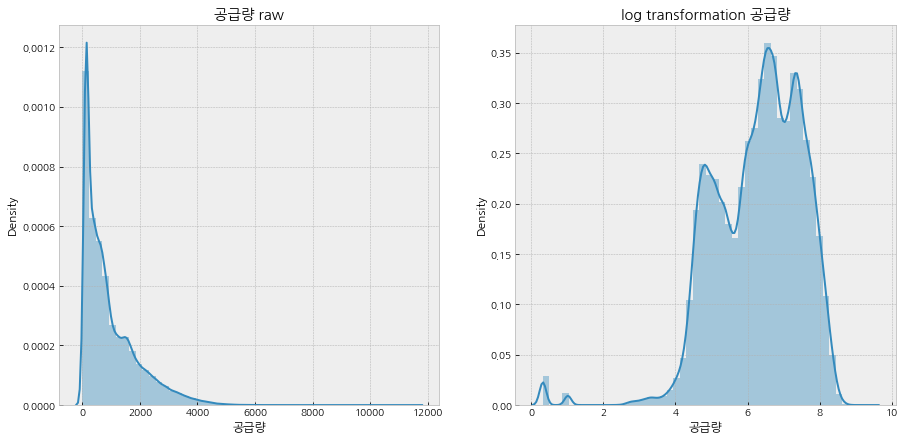

In [11]:
fig, ax = plt.subplots(nrows =1, ncols = 2, figsize = (15, 7))
ax = ax.reshape(2)
sns.distplot(tr_te_mean['공급량'], ax = ax[0])
ax[0].set_title('공급량 raw')
sns.distplot(np.log(tr_te_mean['공급량']), ax = ax[1])
ax[1].set_title('log transformation 공급량')

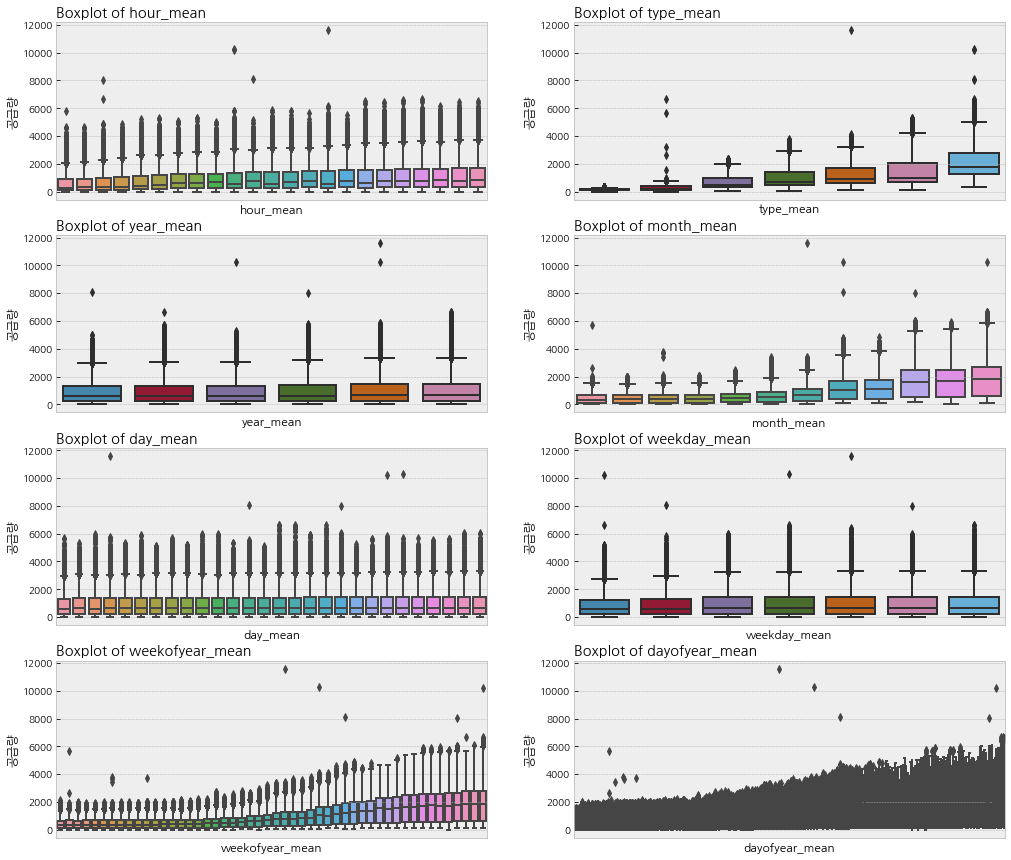

In [12]:
# cat_mean_cols = [col+"_mean" for col in cat_cols]

fig, ax = plt.subplots(nrows = 4, ncols =2, figsize = (17, 15))
ax=ax.reshape(8)
for i, col in enumerate(cat_mean_cols):
    sns.boxplot(data = tr_te_mean, y = '공급량', x = col, ax = ax[i])
    ax[i].set_title(f"Boxplot of {col}", loc = 'left')
    ax[i].set_xticks([])
    

# Linear Regressor

In [13]:
def NMAE(true, pred):
    score = np.mean((np.abs(true-pred))/true)
    return score

In [14]:
tr_te_mean

,hour,type,공급량,year,month,day,weekday,weekofyear,dayofyear,hour_mean,type_mean,year_mean,month_mean,day_mean,weekday_mean,weekofyear_mean,dayofyear_mean
2013-01-01 00:00:00,1.0,A,2497.129,2013,1,1,1,1,1,821,1167,1001,1833,913,983,1739,1608
2013-01-01 01:00:00,2.0,A,2363.265,2013,1,1,1,1,1,683,1167,1001,1833,913,983,1739,1608
2013-01-01 02:00:00,3.0,A,2258.505,2013,1,1,1,1,1,612,1167,1001,1833,913,983,1739,1608
2013-01-01 03:00:00,4.0,A,2243.969,2013,1,1,1,1,1,630,1167,1001,1833,913,983,1739,1608
2013-01-01 04:00:00,5.0,A,2344.105,2013,1,1,1,1,1,715,1167,1001,1833,913,983,1739,1608
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2018-12-31 19:00:00,20.0,H,681.033,2018,12,31,0,1,365,1139,248,1014,1700,957,960,1739,1751
2018-12-31 20:00:00,21.0,H,669.961,2018,12,31,0,1,365,1117,248,1014,1700,957,960,1739,1751
2018-12-31 21:00:00,22.0,H,657.941,2018,12,31,0,1,365,1079,248,1014,1700,957,960,1739,1751
2018-12-31 22:00:00,23.0,H,610.953,2018,12,31,0,1,365,1011,248,1014,1700,957,960,1739,1751


In [15]:
tr_te_mean.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 368088 entries, 2013-01-01 00:00:00 to 2018-12-31 23:00:00
Data columns (total 17 columns):
 #   Column           Non-Null Count   Dtype   
---  ------           --------------   -----   
 0   hour             368088 non-null  category
 1   type             368088 non-null  category
 2   공급량              368088 non-null  float64 
 3   year             368088 non-null  category
 4   month            368088 non-null  category
 5   day              368088 non-null  category
 6   weekday          368088 non-null  category
 7   weekofyear       368088 non-null  category
 8   dayofyear        368088 non-null  category
 9   hour_mean        368088 non-null  int64   
 10  type_mean        368088 non-null  int64   
 11  year_mean        368088 non-null  int64   
 12  month_mean       368088 non-null  int64   
 13  day_mean         368088 non-null  int64   
 14  weekday_mean     368088 non-null  int64   
 15  weekofyear_mean  368088 non-null  

In [16]:
cat_cols

['hour', 'type', 'year', 'month', 'day', 'weekday', 'weekofyear', 'dayofyear']

In [45]:
# subsetting column
X = tr_te_mean.drop(cat_cols, axis = 1)
X = X.drop('공급량', axis = 1)
y = tr_te_mean['공급량']

# transform the data
#X = np.log(X)
y = np.log(y)

In [46]:
import random 
random.seed(1234)


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 100)

In [47]:
print(X_train.describe())
print(y_train.describe())

           hour_mean      type_mean      year_mean     month_mean  \
count  257661.000000  257661.000000  257661.000000  257661.000000   
mean      947.764990     948.472085     947.401885     948.306895   
std       169.271719     626.447695      48.475534     512.810576   
min       612.000000     131.000000     886.000000     448.000000   
25%       821.000000     248.000000     905.000000     475.000000   
50%       970.000000     958.000000     916.000000     637.000000   
75%      1117.000000    1395.000000    1001.000000    1209.000000   
max      1188.000000    2070.000000    1014.000000    1833.000000   

            day_mean   weekday_mean  weekofyear_mean  dayofyear_mean  
count  257661.000000  257661.000000    257661.000000   257661.000000  
mean      947.565010     947.855911       948.080691      948.170728  
std        19.860255      50.167771       520.718218      523.464916  
min       889.000000     849.000000       439.000000      388.000000  
25%       939.000000   

#### 모델 fitting
- Linear Regression
- Ridge Regression
- Lasso Regression

In [48]:
LR = LinearRegression()
LR.fit(X_train, y_train)
pred = LR.predict(X_test)
NMAE(y_test, pred)

0.13583379935797898

In [49]:
RIDGE = Ridge()
RIDGE.fit(X_train, y_train)
pred = RIDGE.predict(X_test)
NMAE(y_test, pred)

0.13583379935806544

In [50]:
LASSO = Lasso()
LASSO.fit(X_train, y_train)
pred = LASSO.predict(X_test)
NMAE(y_test, pred)

0.13598890015326712

#### 각 모델 변수 확인

In [51]:
def get_top_bottom_coef(model, n=5):
    coef = pd.Series(model.coef_, index=X.columns)
    
    coef_high = coef.sort_values(ascending=False).head(n)
    coef_low = coef.sort_values(ascending=False).tail(n)
    return coef_high, coef_low

In [52]:
def get_nmae(model):
    pred = model.predict(X_test)
    nmae = NMAE(y_test, pred)
    print(model.__class__.__name__, 'NMAE:', np.round(nmae, 3))
    return nmae

def get_nmaes(models):
    nmaes = []
    for model in models:
        nmae = get_nmae(model)
        nmaes.append(nmae)
        
    return nmaes

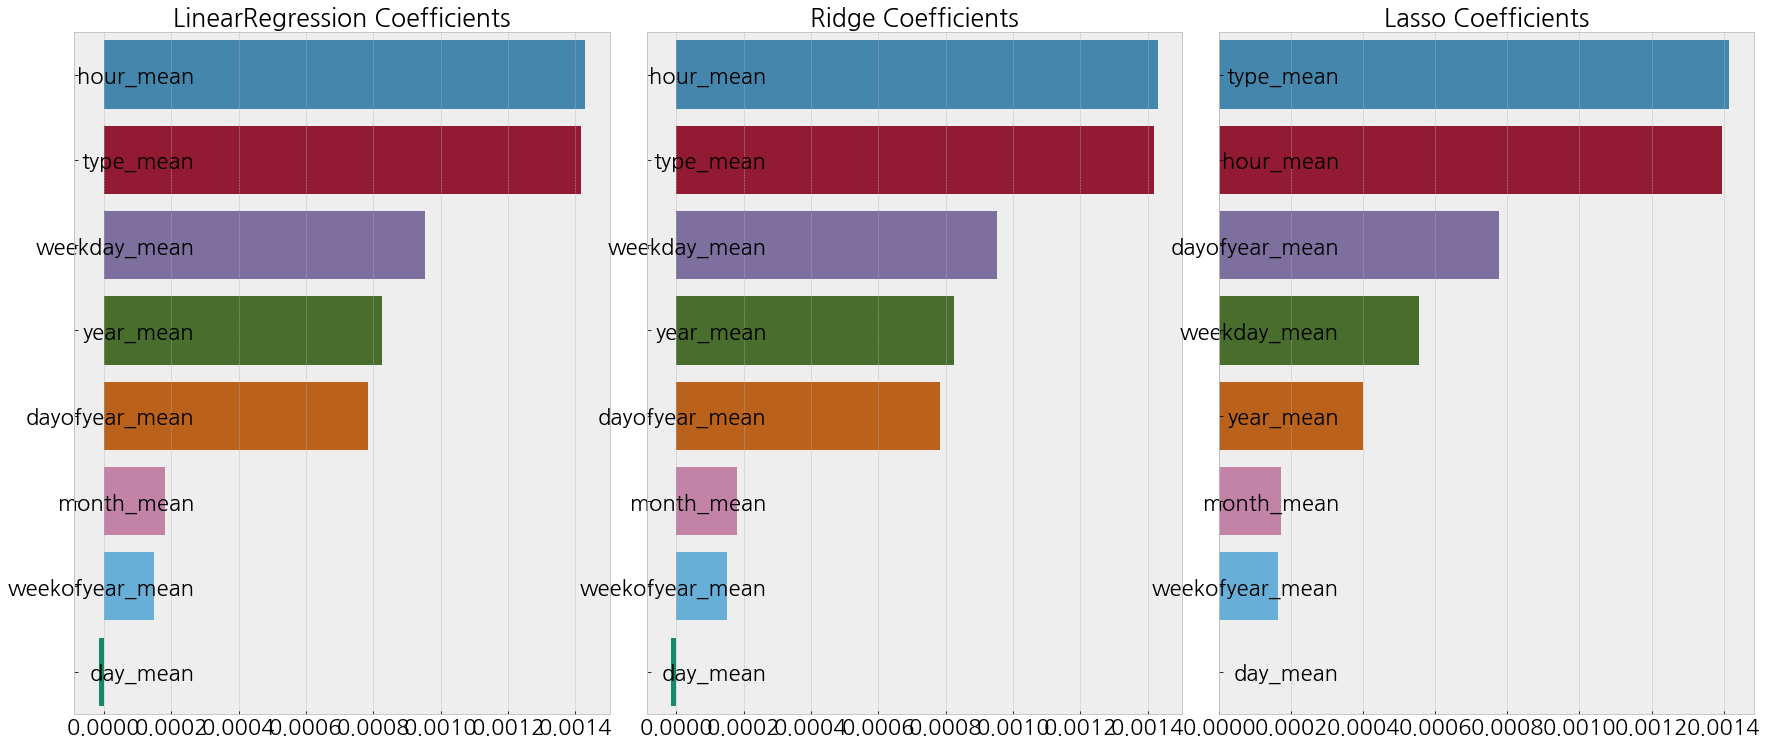

In [53]:
def visualize_coefficient(models):
    fig, axs = plt.subplots(figsize=(24, 10), nrows=1, ncols=3)
    fig.tight_layout()
    
    for i_num, model in enumerate(models):
        coef_high, coef_low = get_top_bottom_coef(model)
        coef_concat = pd.concat([coef_high, coef_low])
        
        axs[i_num].set_title(model.__class__.__name__+' Coefficients', size=25)
        axs[i_num].tick_params(axis='y', direction='in', pad=-120)
        for label in (axs[i_num].get_xticklabels() + axs[i_num].get_yticklabels()):
            label.set_fontsize(22)
        sns.barplot(x=coef_concat.values, y=coef_concat.index, ax=axs[i_num])

models = [LR, RIDGE, LASSO]
visualize_coefficient(models)

In [54]:
def get_avg_nmae_cv(models):
    
    for model in models:
        nmae_list = -cross_val_score(model, X, y, scoring=make_scorer(NMAE, greater_is_better=False), cv=10)
        nmae_avg = np.mean(nmae_list)
        print('\n{0} CV NMAE 값 리스트: {1}'.format(model.__class__.__name__, np.round(nmae_list, 3)))
        print('{0} CV 평균 NMAE 값: {1}'.format(model.__class__.__name__, np.round(nmae_avg, 3)))

models = [LR, RIDGE, LASSO]
get_avg_nmae_cv(models)


LinearRegression CV NMAE 값 리스트: [0.247 0.051 0.231 0.193 0.056 0.19  0.046 0.146 0.131 0.051]
LinearRegression CV 평균 NMAE 값: 0.134

Ridge CV NMAE 값 리스트: [0.247 0.051 0.231 0.193 0.056 0.19  0.046 0.146 0.131 0.051]
Ridge CV 평균 NMAE 값: 0.134

Lasso CV NMAE 값 리스트: [0.248 0.049 0.231 0.194 0.057 0.19  0.047 0.146 0.131 0.051]
Lasso CV 평균 NMAE 값: 0.134


#### Linear regressor hyperparameters

In [55]:
def print_best_params(model, params):
    grid_model = GridSearchCV(model, param_grid=params, scoring=make_scorer(NMAE, greater_is_better=False), cv=5)
    grid_model.fit(X, y)
    nmae = -1*grid_model.best_score_
    print('{0} 5 CV 시 최적 평균 NMAE 값:{1}, 최적 alpha:{2}'.format(model.__class__.__name__, np.round(nmae, 4), grid_model.best_params_))

ridge_params = {'alpha':[0.0001, 0.0005, 0.001, 0.005, 0.01, 0.05, 0.1, 0.5, 1, 5, 10, 50]}
lasso_params = {'alpha':[0.0001, 0.0005, 0.001, 0.005, 0.01, 0.05, 0.1, 0.5, 1, 5, 10, 50]}
print_best_params(RIDGE, ridge_params)
print_best_params(LASSO, lasso_params)

Ridge 5 CV 시 최적 평균 NMAE 값:0.1337, 최적 alpha:{'alpha': 50}
Lasso 5 CV 시 최적 평균 NMAE 값:0.1337, 최적 alpha:{'alpha': 0.1}


LinearRegression NMAE: 0.136
Ridge NMAE: 0.136
Lasso NMAE: 0.136


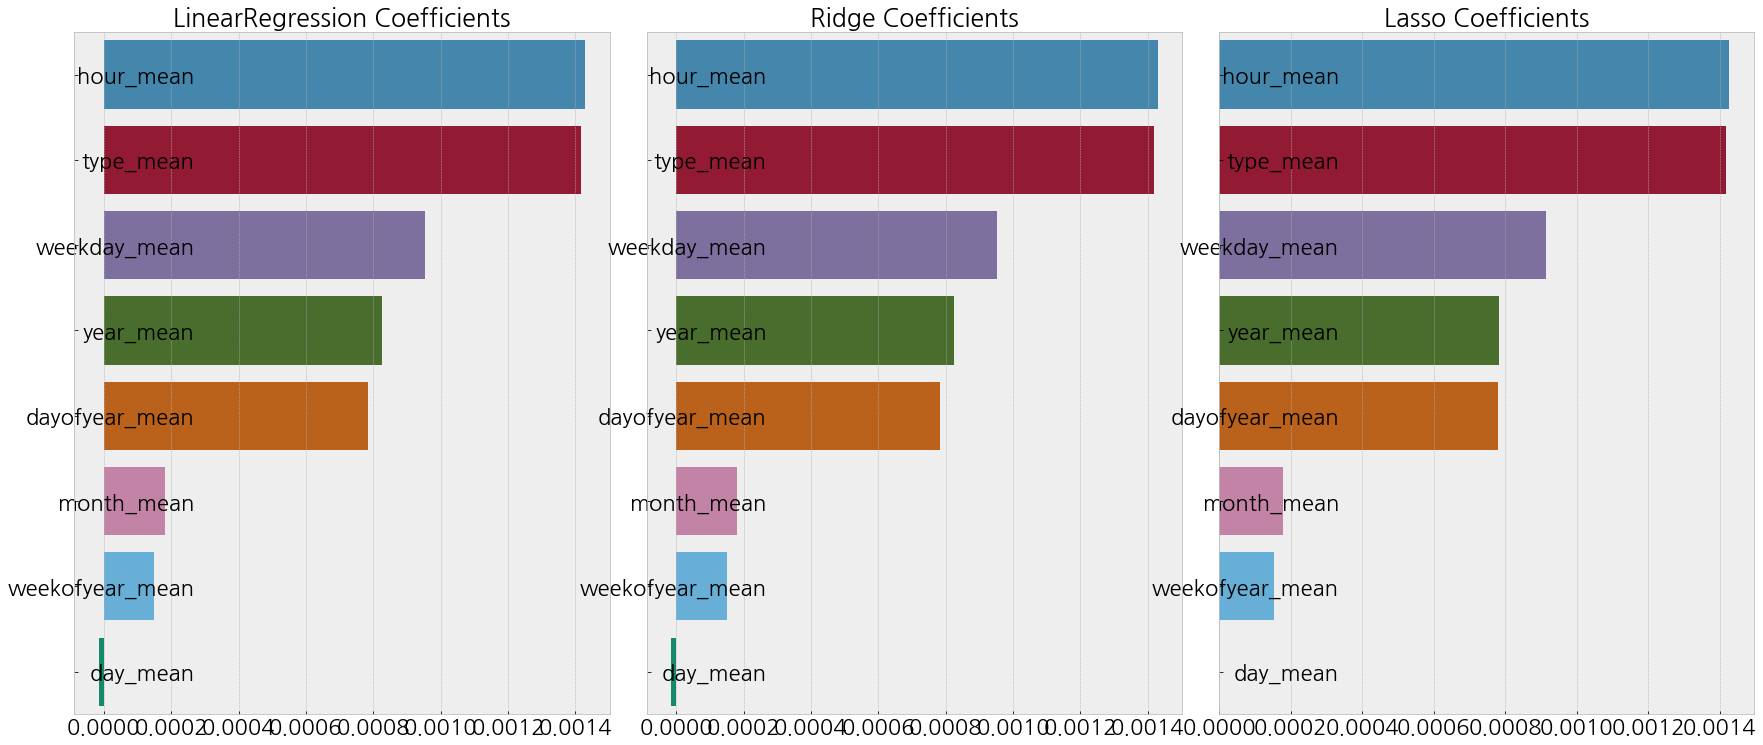

In [56]:
LR = LinearRegression()
LR.fit(X_train, y_train)
RIDGE = Ridge(alpha=50)
RIDGE.fit(X_train, y_train)
LASSO = Lasso(alpha=0.1)
LASSO.fit(X_train, y_train)

models = [LR, RIDGE, LASSO]
get_nmaes(models)

visualize_coefficient(models)

#### 이상치 제거
- siginificat variable 만 check

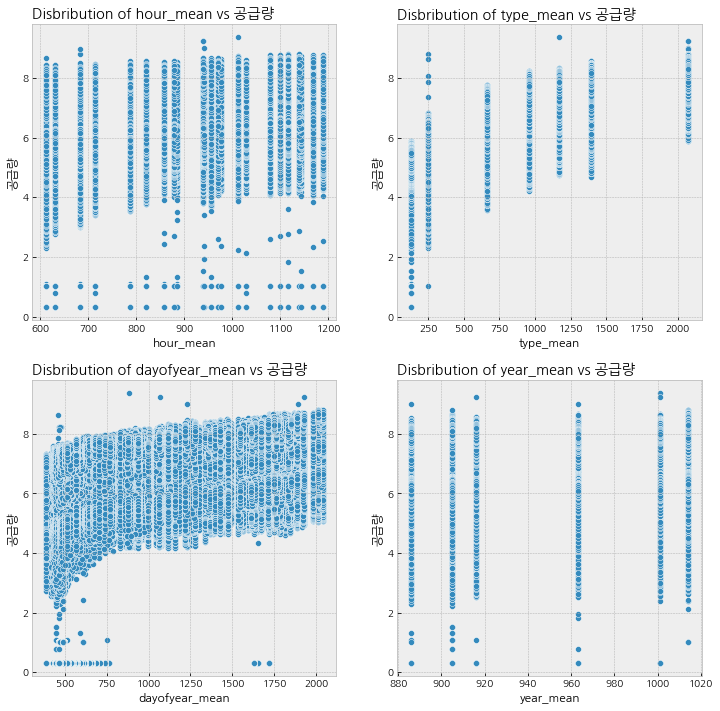

In [57]:
# 분포 확인통해 이상치 유무 및 위치 확인
sig_vars = ['hour_mean', 'type_mean', 'dayofyear_mean', 'year_mean']

fig, ax = plt.subplots(nrows =2, ncols = 2, figsize= (12, 12))
ax = ax.reshape(4)
for i, var in enumerate(sig_vars):
    sns.scatterplot(x = X[var], y = y, ax = ax[i])
    ax[i].set_title(f"Disbribution of {var} vs 공급량", loc='left')


#### TBATS Decomposition

In [30]:
#!pip install tbats

In [31]:
from tbats import TBATS, BATS
#estimator = TBATS(seasonal_periods=(24,24*7, 24*365.25))
#model = estimator.fit(y)
# Forecast 365 days ahead


In [32]:
#y_forecast = model.forecast(steps=365)

# Tree Regressor

In [58]:
xgb_params = {'n_estimators':[500]}
XGBR = XGBRegressor()
print_best_params(XGBR, xgb_params)

XGBRegressor 5 CV 시 최적 평균 NMAE 값:0.0977, 최적 alpha:{'n_estimators': 500}


In [59]:
lgbm_params = {'n_estimators':[500]}
LGBMR = LGBMRegressor()
print_best_params(LGBMR, lgbm_params)

LGBMRegressor 5 CV 시 최적 평균 NMAE 값:0.0904, 최적 alpha:{'n_estimators': 500}


In [60]:
XGBR = XGBRegressor(n_estimators=500)
XGBR.fit(X_train, y_train)
LGBMR = LGBMRegressor(n_estimators=500)
LGBMR.fit(X_train, y_train)

models = [XGBR, LGBMR]
get_nmaes(models)

XGBRegressor NMAE: 0.016
LGBMRegressor NMAE: 0.023


[0.01640271405916307, 0.022688209375076054]

# 혼합 모델

In [36]:
def get_nmae_pred(preds):
    for key in preds.keys():
        pred_value = preds[key]
        nmae = NMAE(y_test, pred_value)
        print('{0} 모델의 NMAE: {1}'.format(key, nmae))

In [37]:
LR = LinearRegression()
LR.fit(X_train, y_train)
RIDGE = Ridge(alpha=0.0001)
RIDGE.fit(X_train, y_train)
LASSO = Lasso(alpha=0.0001)
LASSO.fit(X_train, y_train)

lr_pred = LR.predict(X_test)
ridge_pred = RIDGE.predict(X_test)
lasso_pred = LASSO.predict(X_test)

pred = 0.4 * lr_pred + 0.4 * ridge_pred + 0.2 * lasso_pred
preds = {'최종 혼합': pred,
        'LinearRegression': lr_pred,
        'Ridge': ridge_pred,
        'Lasso': lasso_pred}

get_nmae_pred(preds)

최종 혼합 모델의 NMAE: 0.11032813072678033
LinearRegression 모델의 NMAE: 0.11032667473036438
Ridge 모델의 NMAE: 0.11032667475050377
Lasso 모델의 NMAE: 0.11033569312860252


In [38]:
XGBR = XGBRegressor(n_estimators=500)
LGBMR = LGBMRegressor(n_estimators=500)
XGBR.fit(X_train, y_train)
LGBMR.fit(X_train, y_train)

xgb_pred = XGBR.predict(X_test)
lgbm_pred = LGBMR.predict(X_test)

pred = 0.4 * xgb_pred + 0.6 * lgbm_pred
preds = {'최종 혼합': pred,
        'XGBM': xgb_pred,
        'LGBM': lgbm_pred}

get_nmae_pred(preds)

최종 혼합 모델의 NMAE: 0.018991567174824305
XGBM 모델의 NMAE: 0.016402645881173347
LGBM 모델의 NMAE: 0.022688209375076054


# Stacking Ensembel

In [39]:
def get_stacking_base_datasets(model, X_train_n, y_train_n, X_test_n, n_folds):
    kf = KFold(n_splits=n_folds)
    train_fold_pred = np.zeros((X_train_n.shape[0], 1))
    test_pred = np.zeros((X_test_n.shape[0], n_folds))
    print(model.__class__.__name__, 'model 시작')
    
    for folder_counter, (train_index, valid_index) in enumerate(kf.split(X_train_n)):
        print('\t 폴드 세트: ', folder_counter, '시작')
        X_tr = X_train_n[train_index]
        y_tr = y_train_n[train_index]
        X_te = X_train_n[valid_index]
        
        model.fit(X_tr, y_tr)
        
        train_fold_pred[valid_index, :] = model.predict(X_te).reshape(-1,1)
        
        test_pred[:, folder_counter] = model.predict(X_test_n)
    
    test_pred_mean = np.mean(test_pred, axis=1).reshape(-1,1)
    
    return train_fold_pred, test_pred_mean

In [40]:
X_train_n = X_train.values
X_test_n = X_test.values
y_train_n = y_train.values

lr_train, lr_test = get_stacking_base_datasets(LR, X_train_n, y_train_n, X_test_n, 10)
ridge_train, ridge_test = get_stacking_base_datasets(RIDGE, X_train_n, y_train_n, X_test_n, 10)
lasso_train, lasso_test = get_stacking_base_datasets(LASSO, X_train_n, y_train_n, X_test_n, 10)
xgb_train, xgb_test = get_stacking_base_datasets(XGBR, X_train_n, y_train_n, X_test_n, 10)
lgbm_train, lgbm_test = get_stacking_base_datasets(LGBMR, X_train_n, y_train_n, X_test_n, 10)

LinearRegression model 시작
	 폴드 세트:  0 시작
	 폴드 세트:  1 시작
	 폴드 세트:  2 시작
	 폴드 세트:  3 시작
	 폴드 세트:  4 시작
	 폴드 세트:  5 시작
	 폴드 세트:  6 시작
	 폴드 세트:  7 시작
	 폴드 세트:  8 시작
	 폴드 세트:  9 시작
Ridge model 시작
	 폴드 세트:  0 시작
	 폴드 세트:  1 시작
	 폴드 세트:  2 시작
	 폴드 세트:  3 시작
	 폴드 세트:  4 시작
	 폴드 세트:  5 시작
	 폴드 세트:  6 시작
	 폴드 세트:  7 시작
	 폴드 세트:  8 시작
	 폴드 세트:  9 시작
Lasso model 시작
	 폴드 세트:  0 시작
	 폴드 세트:  1 시작
	 폴드 세트:  2 시작
	 폴드 세트:  3 시작
	 폴드 세트:  4 시작
	 폴드 세트:  5 시작
	 폴드 세트:  6 시작
	 폴드 세트:  7 시작
	 폴드 세트:  8 시작
	 폴드 세트:  9 시작
XGBRegressor model 시작
	 폴드 세트:  0 시작
	 폴드 세트:  1 시작
	 폴드 세트:  2 시작
	 폴드 세트:  3 시작
	 폴드 세트:  4 시작
	 폴드 세트:  5 시작
	 폴드 세트:  6 시작
	 폴드 세트:  7 시작
	 폴드 세트:  8 시작
	 폴드 세트:  9 시작
LGBMRegressor model 시작
	 폴드 세트:  0 시작
	 폴드 세트:  1 시작
	 폴드 세트:  2 시작
	 폴드 세트:  3 시작
	 폴드 세트:  4 시작
	 폴드 세트:  5 시작
	 폴드 세트:  6 시작
	 폴드 세트:  7 시작
	 폴드 세트:  8 시작
	 폴드 세트:  9 시작


In [41]:
Stack_final_X_train = np.concatenate((lr_train, ridge_train, lasso_train, xgb_train, lgbm_train), axis=1)
Stack_final_X_test = np.concatenate((lr_test, ridge_test, lasso_test, xgb_test, lgbm_test), axis=1)

In [42]:
meta_model_lgbm = LGBMRegressor(n_estimators=500)
meta_model_xgbm = XGBRegressor(n_estimators=500)
meta_model_lr = LinearRegression()
meta_model_ridge = Ridge(alpha=0.0001)
meta_model_lasso = Lasso(alpha=0.0001)

In [43]:
meta_model_lgbm.fit(Stack_final_X_train, y_train)
final = meta_model_lgbm.predict(Stack_final_X_test)
nmae = NMAE(y_test, final)
print('스태킹 회귀 모델(LGBM)의 최종 NMAE 값은:', nmae)

meta_model_xgbm.fit(Stack_final_X_train, y_train)
final = meta_model_xgbm.predict(Stack_final_X_test)
nmae = NMAE(y_test, final)
print('스태킹 회귀 모델(XGB)의 최종 NMAE 값은:', nmae)

meta_model_lr.fit(Stack_final_X_train, y_train)
final = meta_model_lr.predict(Stack_final_X_test)
nmae = NMAE(y_test, final)
print('스태킹 회귀 모델(LR)의 최종 NMAE 값은:', nmae)

meta_model_ridge.fit(Stack_final_X_train, y_train)
final = meta_model_ridge.predict(Stack_final_X_test)
nmae = NMAE(y_test, final)
print('스태킹 회귀 모델(RIDGE)의 최종 NMAE 값은:', nmae)

meta_model_lasso.fit(Stack_final_X_train, y_train)
final = meta_model_lasso.predict(Stack_final_X_test)
nmae = NMAE(y_test, final)
print('스태킹 회귀 모델(LASSO)의 최종 NMAE 값은:', nmae)

스태킹 회귀 모델(LGBM)의 최종 NMAE 값은: 0.014015585251974856
스태킹 회귀 모델(XGB)의 최종 NMAE 값은: 0.01260078015813739
스태킹 회귀 모델(LR)의 최종 NMAE 값은: 0.014483016042557435
스태킹 회귀 모델(RIDGE)의 최종 NMAE 값은: 0.014482705557378765
스태킹 회귀 모델(LASSO)의 최종 NMAE 값은: 0.01445251534113564


In [44]:
meta_model_lr.fit(Stack_final_X_train, y_train)
pred = meta_model_lr.predict(Stack_final_X_test)
NMAE(np.expm1(y_test), np.expm1(pred))

0.07215611249967857

# Model Scoring 